In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/darcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cpu'

sublogdir = 'systemnets/MLP'
MLP = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
MLPmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

# sublogdir = 'systemnets/ResNet'
# ResNet = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
# ResNetmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/CNN'
CNN = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
CNNmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/U-Net'
UNet = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
UNetmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

sublogdir = 'systemnets/FNO'
FNO = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)
FNOmodelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

modeldict_NN = {'MLP': MLP,
            #  'ResNet': ResNet,
             'CNN': CNN,
             'U-Net': UNet,
             'FNO': FNO}

modeldict_NGO = {'MLP model NGO': MLPmodelNGO,
            #  'ResNet model NGO': ResNetmodelNGO,
             'CNN model NGO': CNNmodelNGO,
             'U-Net model NGO': UNetmodelNGO,
             'FNO model NGO': FNOmodelNGO}

labels = ['MLP', 'CNN', 'U-Net', 'FNO']

/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../ml/customlayers.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=dtype, device=device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:321: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

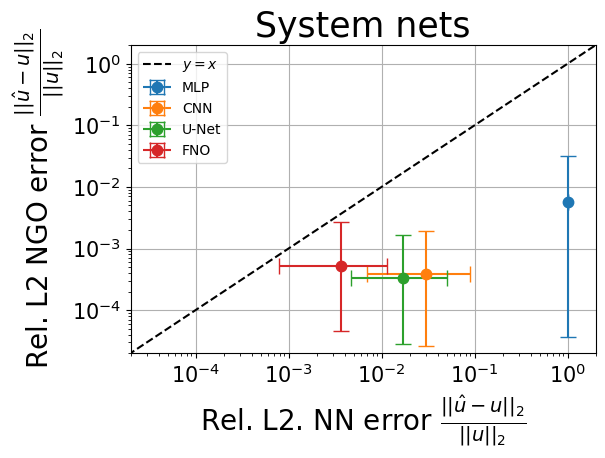

In [61]:
N_samples = 1000

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg_NGO = np.zeros(len(modeldict_NN))
L2_scaled_avg_NN = np.zeros(len(modeldict_NN))
yerr = np.zeros((2,len(modeldict_NN)))
xerr = np.zeros((2,len(modeldict_NN)))

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature2D(n_elements=1, Q=100)
quadrature = UniformQuadrature2D(Q=100)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = torch.tensor(quadrature.w_Omega, device=device)

linestyles=['--','--','--','--','--','--','--','--']
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
# markers = ['o','^','o','^','o','^','o']

dataset = ManufacturedSolutionsSetDarcy(N_samples=N_samples, variables=['x','x'], l_min=[0.5,1], l_max=[0.5,1], device=device)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.plot(np.linspace(0,2,100),np.linspace(0,2,100), color='black', linestyle='--', label=r'$y=x$'))

m=0
for model in modeldict_NN:
    u_exact = discretize_functions(u, x, dtype=modeldict_NN[str(model)].hparams['dtype'], device=device)
    u_hat_NN = modeldict_NN[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L2_scaled_array_NN = weightedrelativeL2_set(w.detach().cpu().numpy(), u_hat_NN, u_exact)
    L2_scaled_avg_NN[m] = np.average(L2_scaled_array_NN)
    q_l_NN = np.quantile(L2_scaled_array_NN, q_low)
    q_h_NN = np.quantile(L2_scaled_array_NN, q_high)
    xerr[:,m] = np.array([L2_scaled_avg_NN[m] - q_l_NN, -L2_scaled_avg_NN[m] + q_h_NN])
    m+=1

m=0
for model in modeldict_NGO:
    u_exact = discretize_functions(u, x, dtype=modeldict_NGO[str(model)].hparams['dtype'], device=device)
    u_hat_NGO = modeldict_NGO[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L2_scaled_array_NGO = weightedrelativeL2_set(w.detach().cpu().numpy(), u_hat_NGO, u_exact)
    L2_scaled_avg_NGO[m] = np.average(L2_scaled_array_NGO)
    q_l_NGO = np.quantile(L2_scaled_array_NGO, q_low)
    q_h_NGO = np.quantile(L2_scaled_array_NGO, q_high)
    yerr[:,m] = np.array([L2_scaled_avg_NGO[m] - q_l_NGO, -L2_scaled_avg_NGO[m] + q_h_NGO])
    m+=1

for m in range(len(modeldict_NN)):
    plots.append(ax.errorbar(L2_scaled_avg_NN[m], L2_scaled_avg_NGO[m], xerr=xerr[:,m,None], yerr=yerr[:,m,None], fmt=".-", capsize=6, ms=15, label=labels[m], color=colors[m], linestyle=linestyles[m]))

plt.legend(fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(2e-5,2e0)
ax.set_ylim(2e-5,2e0)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
# ax.set_xticklabels([r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xlabel(r'Rel. L2. NN error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 NGO error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.grid()
ax.set_title('System nets', fontsize=size_title)
plt.savefig("systemnets.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("systemnets.svg", bbox_inches='tight')#, transparent=True)

plt.show()

In [9]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:2'

sublogdir = 'massconservation'

# dataNGO = loadmodelfromlabel(model=NeuralOperator, label='dataNGO', logdir=logdir, sublogdir=sublogdir, device=device)
# dataNGO.hparams['discretization_device'] = 'cuda:3'
# dataNGO.hparams['assembly_device'] = 'cpu'
# dataNGO.__init__(dataNGO.hparams)
# dataNGO.to(device)

# modelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
# modelNGO.hparams['discretization_device'] = 'cuda:2'
# modelNGO.hparams['assembly_device'] = 'cpu'
# modelNGO.hparams['n_timesteps'] = 3
# modelNGO.hparams['Dt'] = 1/3
# modelNGO.hparams['output_coefficients'] = True
# modelNGO.__init__(modelNGO.hparams)
# modelNGO.to(device)

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
# projection.hparams['dtype'] = torch.float64
# projection.hparams['precision'] = 64
projection.hparams['discretization_device'] = 'cuda:2'
projection.hparams['n_timesteps'] = 3
projection.hparams['Dt'] = 1/3
projection.hparams['output_coefficients'] = True
projection.__init__(projection.hparams)
# FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
# FEM.hparams['modeltype'] = 'FEM'
# FEM.hparams['dtype'] = torch.float64
# FEM.hparams['precision'] = 64
# FEM.hparams['Neumannseries'] = False
# FEM.hparams['discretization_device'] = 'cuda:3'
# FEM.__init__(FEM.hparams)


modeldict = {'Projection': projection}#,
             #'FEM': FEM,
             #'NN': NN,
             #'DeepONet': DeepONet,
             #'VarMiON': VarMiON,
            #'Data NGO': dataNGO,
            #'Data-free NGO': datafreeNGO,
            #'Model NGO': modelNGO}

1
Projection
Memory allocated: 502.28 MB
Memory reserved: 3724.00 MB
Memory allocated: 502.28 MB
Memory reserved: 3724.00 MB
0.03245095475298611
0.014140130570463639
0.02590191177247527
Memory allocated: 502.28 MB
Memory reserved: 3724.00 MB


/tmp/ipykernel_1084368/3077107023.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


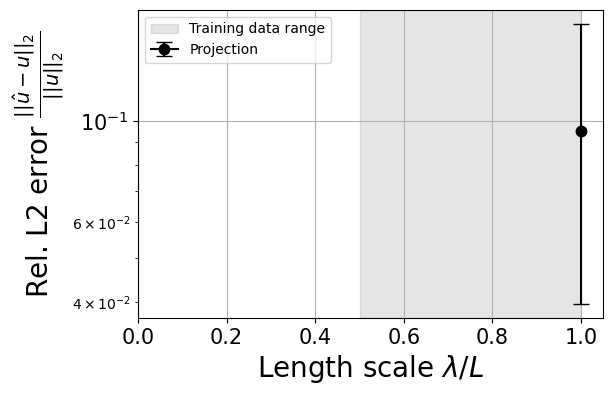

In [22]:
N_samples = 10

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low


# l = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
l = np.array([1])


L2_scaled_avg = np.zeros((len(modeldict),len(l)))
yerr = np.zeros((len(modeldict),2,len(l)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[3,3,3], Q=[99,99,99])
x = quadrature.xi
w = quadrature.w

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','C0','C2','C3','C4']
    
for i in range(len(l)):
    print(l[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[1,l[i],l[i]], l_max=[1,l[i],l[i]], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Length scale $\lambda/L$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.svg", bbox_inches='tight')#, transparent=True)
# plt.savefig("lengthscales.pdf", bbox_inches='tight')#, transparent=True)

plt.show()

[autoreload of NeuralOperator failed: Traceback (most recent call last):
  File "/home/prins/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/prins/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/data/storage8/prins/anaconda3/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/tdarcy/NeuralOperator.py", line 310
    C_hat 

0.05
Projection
Memory allocated: 30.35 MB
Memory reserved: 5610.00 MB
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Memory allocated: 30.35 MB
Memory reserved: 62.00 MB
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Memory allocated: 30.35 MB
Memory reserved: 62.00 MB
Data NGO
Memory allocated: 30.35 MB
Memory reserved: 62.00 MB
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63

/tmp/ipykernel_3471317/3646490777.py:70: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(tau, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


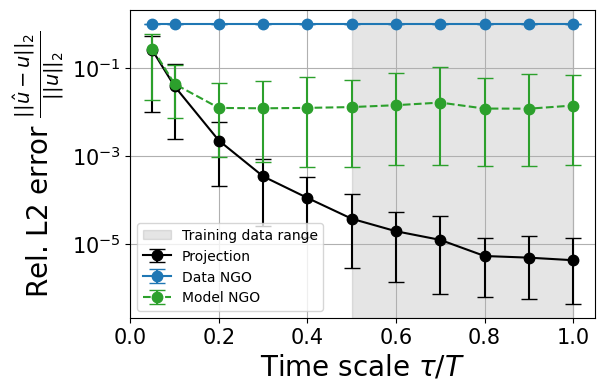

In [5]:
N_samples = 100

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low


tau = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# tau = np.array([1])


L2_scaled_avg = np.zeros((len(modeldict),len(tau)))
yerr = np.zeros((len(modeldict),2,len(tau)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

quadrature = GaussLegendreQuadrature(n_elements=[3,3,3], Q=[12,12,12])
x = quadrature.xi
w = quadrature.w

linestyles=['-','-','--','--','--','--','--','--','--','--']
colors = ['black','C0','C2','C3','C4']
    
for i in range(len(tau)):
    print(tau[i])
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[tau[i],1,1], l_max=[tau[i],1,1], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u0 = dataset.u0
    m=0
    for model in modeldict:
        print(str(model))
        modeldict[str(model)].hparams['assembly_batch_size'] = N_samples
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        print(f"Memory allocated: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
        print(f"Memory reserved: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time scale $\tau/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.grid()
# ax.set_title('FNO', fontsize=size_title)
for model in modeldict:
    plots.append(ax.errorbar(tau, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=1)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower left')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

# plt.savefig("FNO.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("timescales.svg", bbox_inches='tight')#, transparent=True)
plt.savefig("timescales.pdf", bbox_inches='tight')#, transparent=True)
plt.show()